# 5章 GLMの尤度比検定と検定の非対称性

### ライブラリのインポート

In [139]:
import polars as pl
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

from scipy.stats import poisson

from statsmodels.stats.anova import anova_lm

## 5.1 統計的な検定のわくぐみ

## 5.2 尤度検定の例題: 逸脱度の差を調べる

In [120]:
# データを読み込む
d = pl.read_parquet("../data/ch 03/data3a.parquet").to_pandas()

# 一般化線形モデル
# 一定
form_const = "y ~ 0 + np.power(x, 0)"
model_const = smf.glm(formula = form_const, data = d, family = sm.families.Poisson()).fit()
# x
form_x = "y ~ x"
model_x = smf.glm(formula = form_x, data = d, family = sm.families.Poisson()).fit()

# モデルのあてはまりの悪さ
print("\n一定モデル")
print("log L:", np.round(model_const.llf, 1))# 対数尤度
print("deviance - 2log L:", np.round(-2 * model_const.llf, 1))# 逸脱度?
print("redisual  deviance:", np.round(model_const.deviance, 1))# 残差逸脱度
print("AIC:", np.round(model_const.aic, 1))# AIC

print("\nxモデル")
print("log L:", np.round(model_x.llf, 1))# 対数尤度
print("deviance - 2log L:", np.round(-2 * model_x.llf, 1))# 逸脱度?
print("redisual  deviance:", np.round(model_x.deviance, 1))# 残差逸脱度
print("AIC:", np.round(model_x.aic, 1))# AIC


一定モデル
log L: -237.6
deviance - 2log L: 475.3
redisual  deviance: 89.5
AIC: 477.3

xモデル
log L: -235.4
deviance - 2log L: 470.8
redisual  deviance: 85.0
AIC: 474.8


表5.1 一定モデルと$x$モデルんお対数尤度・逸脱度・AIC
| モデル | k | $\log L$ | deviance -2 $\log L$ | residual deviance | AIC |
| ---- | ---- | ---- | ----- | ---- | ---- |
| 一定 | 1 | -237.6 | 475.3 | 89.5 | 477.3 |
| $x$ | 2 | -235.4 | 470.8 | 85.0 | 474.8 |

尤度比検定では尤度比の対数をとり2をかける.\
すなわち逸脱度の差

$\Delta _ {1, 2} = -2 \times ( \log L_1 - \log L_2 )$

を統計検定料として使います.

In [99]:
print("逸脱度の差:", np.round(-2 * ( model_const.llf - model_x.llf ), 1))

逸脱度の差: 4.5


## 5.3 2種類の過誤と統計的な検定の非対称性

## 5.4 帰無仮説を棄却するための有意水準

### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法

In [100]:
print("逸脱度の差", np.round(model_const.deviance - model_x.deviance, 4))
delta_result = np.round(model_const.deviance - model_x.deviance, 2)

逸脱度の差 4.5139


In [101]:
d["y_rnd"] = poisson.rvs(mu = d["y"].mean(), loc = 0, size = len(d), random_state = 1192)

In [102]:
# 一般化線形モデル
# 一定
form_const = "y_rnd ~ 0 + np.power(x, 0)"
model_const = smf.glm(formula = form_const, data = d, family = sm.families.Poisson()).fit()
# x
form_x = "y_rnd ~ x"
model_x = smf.glm(formula = form_x, data = d, family = sm.families.Poisson()).fit()
print("逸脱度の差", np.round(model_const.deviance - model_x.deviance, 4))

逸脱度の差 0.2293


手順
1. 平均$\bar{y}$のポアソン乱数を```d["y_rnd]```に格納する.
2. ```d["y_rnd]```に対する一定モデル, $x$モデルの```glm()```の推定結果を,それぞれ```model_const```,```model_x```に格納する.
3. 逸脱度の差```model_const.deviance - model_x.deviance```を計算する.

In [103]:
deltas = []

for i in range(2, 2 + 1000):
    d["y_rnd"] = poisson.rvs(mu = d["y"].mean(), loc = 0, size = len(d), random_state = i * 2)

    # 一般化線形モデル
    # 一定
    form_const = "y_rnd ~ 0 + np.power(x, 0)"
    model_const = smf.glm(formula = form_const, data = d, family = sm.families.Poisson()).fit()
    # x
    form_x = "y_rnd ~ x"
    model_x = smf.glm(formula = form_x, data = d, family = sm.families.Poisson()).fit()

    deltas.append(np.round(model_const.deviance - model_x.deviance, 4))

s_deltas = pl.Series("delta", deltas).to_pandas()

In [104]:
s_deltas.describe()

count    1000.000000
mean        0.983841
std         1.402084
min         0.000000
25%         0.090150
50%         0.401100
75%         1.230500
max        10.595300
Name: delta, dtype: float64

Text(0.5, 1.0, '図5.4 逸脱度の差ΔD1,2の確率分布')

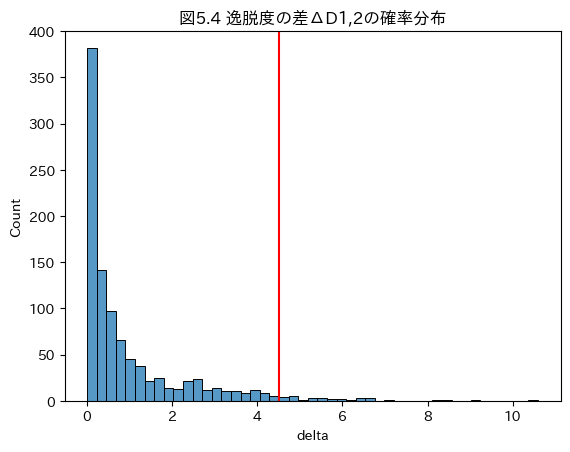

In [107]:
sns.histplot(data = s_deltas)
plt.axvline(x = delta_result, ymin = 0, ymax = 400, color = "red")
plt.ylim(0, 400)
plt.title("図5.4 逸脱度の差ΔD1,2の確率分布")

In [108]:
len(s_deltas[ s_deltas >= delta_result ])

32

実測値の逸脱度の差4.5より大きかったシミュレーション値は32個あった.\
「逸脱度の差が4.5より大きくなる確率」は$32/1000$,すなわち$P = 0.032$ということになる.

In [114]:
s_deltas.quantile(q = 0.95).round(2)

4.03

逸脱度の差が4.03までは「よくある差」とみなす.

### 5.4.2 方法(2) $\chi ^ 2$分布を使った近似値計算

## 5.5 「帰無仮説を棄却できない」は「差がない」ではない

## 5.6 検定とモデル選択,そして推定された統計モデルの解釈

## 5.7 この章のまとめと参考文献
* Neyman-Pearsonの統計学的検定のわくぐみでは,パラメータ数の少ないモデルを帰無仮説と位置づけ,帰無仮説が棄却できるかどうかの確率評価に専念する.
* 尤度比検定の検定統計量はふたつの統計モデルの逸脱度差である.
* 検定における過誤は2種類あるが,Neyman-Pearsonの検定の枠組みでは帰無仮説の誤棄却を重視する.
* 帰無仮説を棄却する優位水準 $\alpha$ の大きさは解析者が任意に決めるものであり,たとえば $\alpha = 0.05$ が良く使われているが,これは何か特別な根拠に基づくものではない.
* NeymanPearsonの検定のわくぐみでは,第一種の過誤の大きさを正確に評価できるが,いっぽうで帰無仮説が棄却できない場合の結論は何も言えない,つまり判断を保留するしかない.
* 検定やモデル選択の結果だけにちゅうもくするだけではなく,推定された統計モデルが対象となる現象の挙動を,どのように予測しているかも確認するべきだ.

* Hoel 「入門数理統計学」
* Hoelら「統計理論入門」
* 東京大学教養学部統計学教室編「自然科学の統計学」
* Roff「生物学のための計算統計学-最尤法,ブートストラップ,無作為化法」